# CSE 252A Computer Vision I Fall 2019 - Homework 5

## Instructor: Ben Ochoa
### Assignment Published On: Thursday, November 21, 2019
### Due On: Saturday, December 7, 2019 11:59 pm

## Instructions
* Review the academic integrity and collaboration policies on the course website.
  * This assignment must be completed individually.
* All solutions must be written in this notebook.
  * Programming aspects of the assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you may do so. It has only been provided as a framework for your solution.
* You may use Python packages (such as NumPy and SciPy) for basic linear algebra, but you may not use packages that directly solve the problem.
  * If you are unsure about using a specific package or function, then ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as `.ipynb` file.
  * Submit both files (`.pdf` and `.ipynb`) on Gradescope.
  * **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy: assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances.**

## Problem 1: Optical Flow [14 pts]

In this problem, the multi-resolution Lucas-Kanade algorithm for estimating optical flow will be implemented, and the data needed for this problem can be found in the folder 'optical_flow_images'.

An example optical flow output is shown below - this is not a solution, just an example output.

![title](optical_flow_images/sample_optical_flow_output.png)

### Part 1: Multi-resolution Lucas-Kanade implementation [6 pts]

Implement the Lucas-Kanade method for estimating optical flow. The function 'LucasKanadeMultiScale' needs to be completed. You can implement 'upsample_flow' and 'OpticalFlowRefine' as 2 building blocks in order to complete this.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm_notebook

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.title(titleStr)
    plt.show()
    

images=[]
for i in range(1,5):
    images.append(plt.imread('optical_flow_images/im'+str(i)+'.png')
                  [:,:288,:])
# each image after converting to gray scale is of size -> 400x288

<class 'numpy.ndarray'>


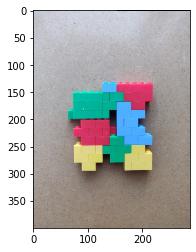

In [2]:
plt.imshow(images[0])
print(type(images[0]))

In [26]:
# you can use interpolate from scipy
# You can implement 'upsample_flow' and 'OpticalFlowRefine' 
# as 2 building blocks in order to complete this.
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d as conv2
def downsample(im, scale = 2, sigma = 3):
    im_downsized = im[::scale, ::scale]
    im_downsized = gaussian_filter(im_downsized, sigma)
    return im_downsized

def upsample_flow(u_prev, v_prev):
    ''' You may implement this method to upsample optical flow from
    previous level
    u_prev, v_prev -> optical flow from prev level
    u, v -> upsampled optical flow to the current level
    '''
    """ ==========
    YOUR CODE HERE
    ========== """
    u = scipy.ndimage.zoom(u_prev, 2, order=1)
    v = scipy.ndimage.zoom(v_prev, 2, order=1)
    u = u * 2
    v = v * 2
    return u, v

def LucasKanade(im1, im2, window):
    u = np.zeros(im1.shape)
    v = np.zeros(im1.shape)
    
    It = im2 - im1
    
    [sy, sx] = np.gradient(im1)
    sy = -sy
    Ixx = sx**2
    Iyy = sy**2
    Ixy = sx*sy
    Ixt = -sx*It
    Iyt = -sy*It
    
    ker = np.ones([window, window])
    im_Ixx = conv2(Ixx, ker, boundary='fill', mode='same')
    im_Iyy = conv2(Iyy, ker, boundary='fill', mode='same')
    im_Ixy = conv2(Ixy, ker, boundary='fill', mode='same')
    im_Ixt = conv2(Ixt, ker, boundary='fill', mode='same')
    im_Iyt = conv2(Iyt, ker, boundary='fill', mode='same')
    
    for row in range(Ixx.shape[0]):
        for col in range(Ixx.shape[1]):
            C = np.zeros([2,2])
            C[0][0] = im_Ixx[row,col]
            C[1][0] = im_Ixy[row,col]
            C[0][1] = C[1][0]
            C[1][1] = im_Iyy[row,col]

            b = np.zeros([2,1])
            b[0][0] = im_Ixt[row,col]
            b[1][0] = im_Iyt[row,col]
            u[row][col], v[row][col] = np.dot(np.linalg.pinv(C),b)
    return u,v
    
def LucasKanade_displaced(im1, im2, window, u_star, v_star):
    
    s = np.shape(im1)
    w = window //2 

    u = u_star
    v = v_star
    [sy, sx] = np.gradient(im1)
    It = im2 - im1
    for row in range(w,s[0]-w):
        for col in range(w, s[1]-w):

            y = row + v_star[row][col]
            x = col + u_star[row][col]
            
            left = max(x - w ,0)
            right = min(x + w, s[1] - 1)
            up = min(y + w ,s[0] - 1)
            down = max(y - w, 0)

            Ixx = np.sum(sx[down:up, left:right]**2)
            Iyy = np.sum(sy[down:up, left:right]**2)
            Ixy = np.sum(sx[down:up, left:right]*sy[down:up, left:right])
            Ixt = np.sum(-sx[down:up, left:right]*It[down:up, left:right])
            Iyt = np.sum(-sy[down:up, left:right]*It[down:up, left:right])
            
            C = np.zeros([2,2])
            C[0][0] = Ixx
            C[1][0] = Ixy
            C[0][1] = C[1][0]
            C[1][1] = Iyy

            b = np.zeros([2,1])
            b[0][0] = Ixy
            b[1][0] = Iyt
            #u[row][col], v[row][col] = np.dot(np.linalg.pinv(C),b)
            uv = np.dot(np.linalg.pinv(C),b)
            u[row][col] = u[row][col] + uv[0]
            v[row][col] = v[row][col] + uv[1]
            
    return u,v
            
def OpticalFlowRefine(im1,im2,window, u_prev=None, v_prev=None):
    '''
    Inputs: the two images at current level and window size
    u_prev, v_prev - previous levels optical flow
    Return u,v - optical flow at current level
    '''
    # upsample flow from previous level
    sigma = 1
    im1 = gaussian_filter(im1, sigma)
    im2 = gaussian_filter(im2, sigma)
    
    if u_prev == None and v_prev == None:
        u,v = LucasKanade(im1, im2, window)
    else:
        u_prev, v_prev = upsample_flow(u_prev, v_prev)
        u, v = LucasKanade_displaced(im1, im2, window, u_prev, v_prev)

    #u = np.zeros(im1.shape)
    #v = np.zeros(im1.shape)
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    return u, v

In [27]:
def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    
    """ ==========
    YOUR CODE HERE
    ========== """
    # You can call OpticalFlowRefine iteratively
    pyramid1 = [im1]
    pyramid2 = [im2]
    for _ in range(numLevels-1):
        im1 = downsample(im1)
        im2 = downsample(im2)
        pyramid1.append(im1)
        pyramid2.append(im2)
    
    u_prev = None
    v_prev = None
    for i in range(numLevels):
        u_prev, v_prev = OpticalFlowRefine(pyramid1[numLevels-i-1],
            pyramid2[numLevels-i-1],window, u_prev=None, v_prev=None)
    u = u_prev
    v = v_prev
    return u, v

In [19]:
window = 100
numLevels = 3
u,v = LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]), 
                        window, numLevels)

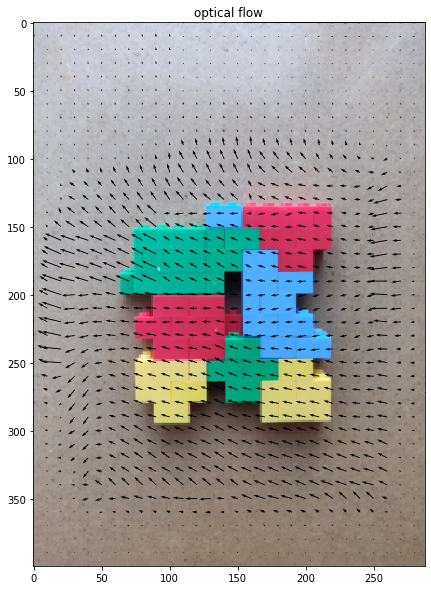

In [21]:

#u,v = LucasKanade(grayscale(images[0]),grayscale(images[1]),window)
title = 'optical flow'
plot_optical_flow(images[0],u,v,title)

### Part 2: Number of levels [2 pts]

Plot optical flow for the pair of images im1 and im2 for different number of levels mentioned below. Comment on the results and justify.<br>
(i) window size = 13, numLevels = 1<br>
(ii) window size = 13, numLevels = 3<br>
(iii) window size = 13, numLevels = 5<br>
So, you are expected to provide 3 outputs here<br>

Note: if numLevels = 1, then it means the optical flow is only computed at the image resolution i.e. no downsampling

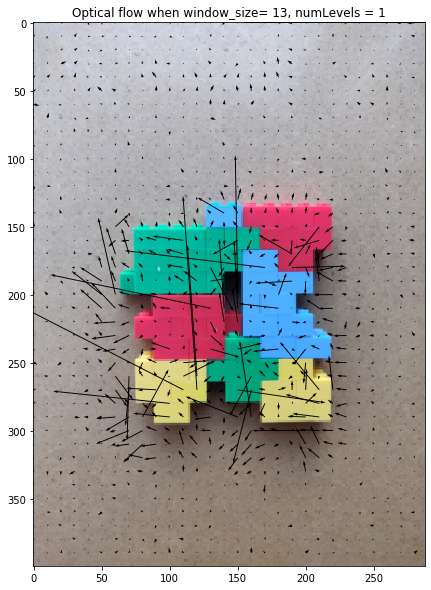

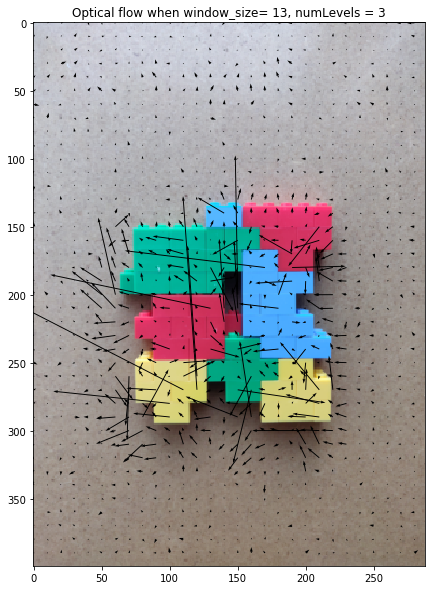

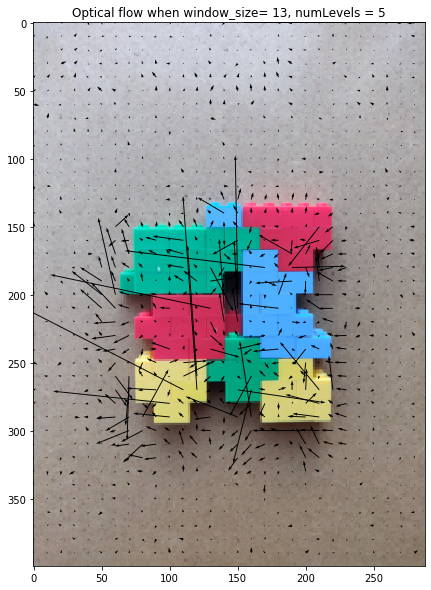

In [28]:
numLevels = [1,3,5]
window_size = 13
for n in numLevels:
    u,v = LucasKanadeMultiScale(grayscale(images[0]),grayscale
                                (images[1]), window_size, n)
    title = "Optical flow when window_size= {}, numLevels = {}".
    format(window_size, n)
    plot_optical_flow(images[0],u,v,title)
    

#### Your Comments on the results of Part 2:

It looks like there is some bug in my code, however, my intuition is that the higher the level, the optical flow would be more detailed since tiny motion would be illustrated more clear.

### Part 3: Window size [3 pts]

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which leads to observable difference in the results. Comment on the effect of window size on results and justify. For this part fix the number of levels to be 3.

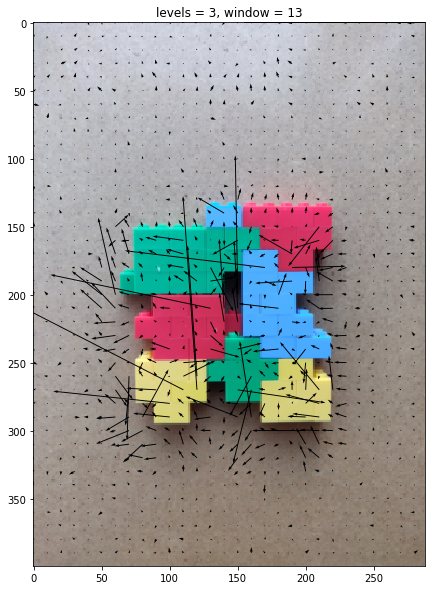

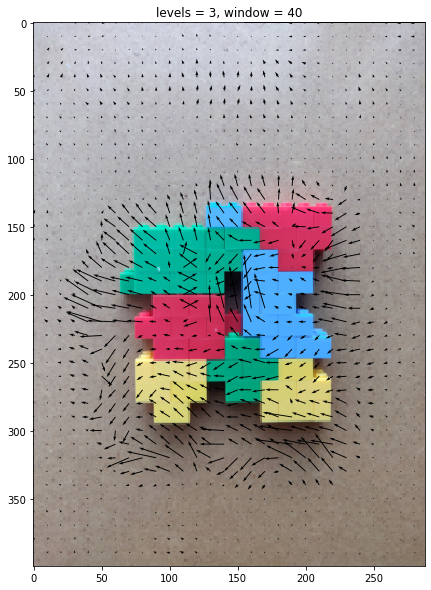

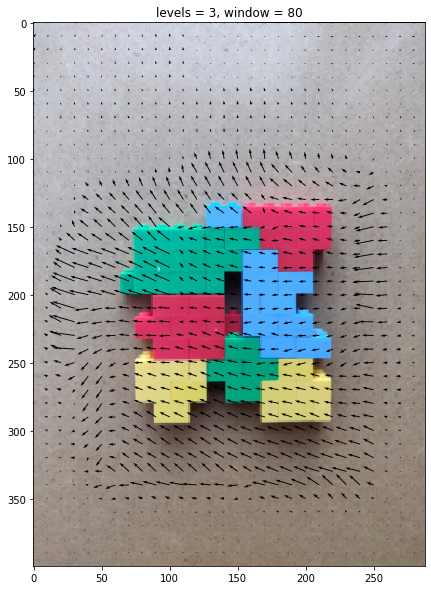

In [22]:
# Example code, change as required
numLevels=3

w1, w2, w3 = 13, 40, 80
for window in [w1, w2, w3]:
    U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                              window,numLevels)
    plot_optical_flow(images[0],U,V, \
                      'levels = ' + str(numLevels) + ', window = '+str
                      (window))

#### Your Comments on the results of Part 3:

If we use too small window size, it seems like the motion flow's direction is disordered, so as the magnitude, jumping too high or too low at different places.
If the window size is too big, the motion flow would be inconsistent.

### Part 4: All pairs [3 pts]

Find optical flow for the pairs (im1,im2), (im1,im3), (im1,im4) using one good window size and number of levels. Does the optical flow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

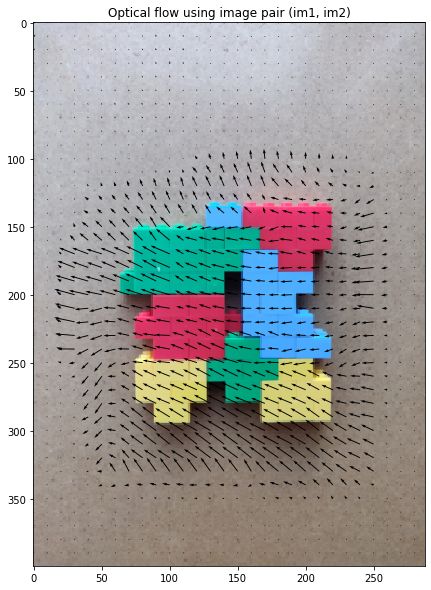

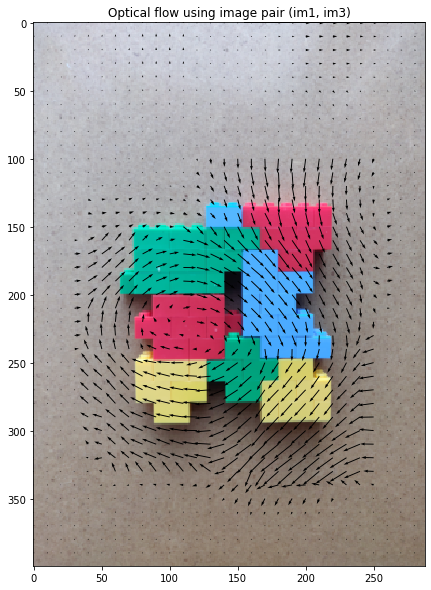

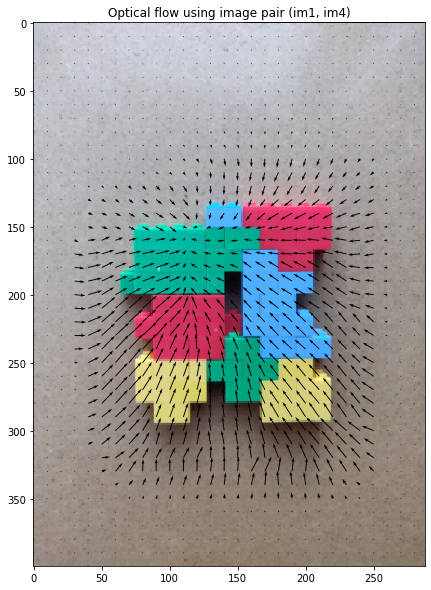

In [48]:
# Your code here
# use one fixed window and numLevels for all pairs
im_idx = [1,2,3]
window_size = 80
for i in im_idx:
    u,v = LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[i])
                                , window_size, n)
    title = "Optical flow using image pair (im1, im{})".format(i+1)
    plot_optical_flow(images[0],u,v,title)

#### Your Comments on the results of Part 4:
The first two image pairs look consistent with the motion shifting to the left and rotating clockwise respectively. However the third image pair's motion field is inconsistent. Such inconsistence might be caused by the light intensity reduction around the center and appears that the image has inward motion.

## Problem 2: Machine Learning [12 pts]

In this problem, you will implement several machine learning solutions for computer vision problems.

### Part 1: Initial setup [1 pts]

Follow the directions on https://pytorch.org/get-started/locally/ to install Pytorch on your computer. 

Note: You will not need GPU support for this assignment so don't worry if you don't have one. Furthermore, installing with GPU support is often more difficult to configure so it is suggested that you install the CPU only version. TA's will not provide any support related to GPU or CUDA.

Run the torch import statements below to verify your instalation.

Download the MNIST data from http://yann.lecun.com/exdb/mnist/.

Download the 4 zipped files, extract them into one folder, and change the variable 'path' in the code below. (Code taken from https://gist.github.com/akesling/5358964 )

Plot one random example image corresponding to each label from training data.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import numpy as np
x = torch.rand(5, 3)
print(x)

tensor([[0.0775, 0.0456, 0.1560],
        [0.6111, 0.4498, 0.1634],
        [0.1361, 0.2556, 0.0629],
        [0.1733, 0.6295, 0.8031],
        [0.3602, 0.1469, 0.2418]])


In [3]:
import os
import struct

# Change path as required
path = "mnist/"

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, 
                                                        cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

In [54]:
# Understand the shapes of the each variable carying data
print(trainData.shape, testLabels.shape)
print(testData.shape, testLabels.shape)

(60000, 28, 28) (10000,)
(10000, 28, 28) (10000,)


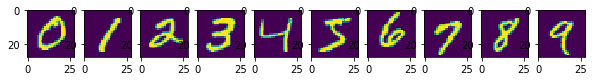

In [60]:
# display one image from each label
# """ ==========
# YOUR CODE HERE
# ========== """
img_list = []
num_list = []
i = 0
while len(img_list) < 10:
    if trainLabels[i] not in num_list:
        num_list.append(trainLabels[i])
        img_list.append((trainLabels[i], trainData[i]))
    i += 1
img_list.sort()
fig, ax = plt.subplots(1,10, figsize = (10,10))
for i, img in img_list:
    ax[i].imshow(img)

Some helper functions are given below.

In [4]:
# a generator for batches of data
# yields data (batchsize, 28, 28) and labels (batchsize)
# if shuffle, it will load batches in a random order
from tqdm import tqdm_notebook
import time

#for i in tqdm_notebook(range(100),desc='demo：'):
#    time.sleep(0.01)

def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in tqdm_notebook(DataBatch(testData,testLabels,
                    batchsize,shuffle=False),desc='testing time: '):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print('Random classifier accuracy: %f' % 
      test(testData, testLabels, randomClassifier))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Random classifier accuracy: 10.200000


In [63]:
print(RandomClassifier(trainData[2]))

### Part 2: Confusion Matrix [2 pts]
Here you will implement a function that computes the confusion matrix for a classifier.
The matrix (M) should be nxn where n is the number of classes.
Entry M[i,j] should contain the fraction of images of class i that was classified as class j.
Can you justify the accuracy given by the random classifier?

In [11]:
# Using the tqdm module to visualize run time is suggested
# from tqdm import tqdm

# It would be a good idea to return the accuracy, along with the confusion 
# matrix, since both can be calculated in one iteration over test data, to 
# save time
import matplotlib.pyplot as plt
def Confusion(testData, testLabels, classifier):
    pred = classifier(testData)
    M=np.zeros((10,10))
    acc=0.0
    """ ==========
    YOUR CODE HERE
    ========== """
    for i in range(len(testData)):
       
        M[testLabels[i],pred[i]] += 1
    s = np.sum(M,1)
    correct = [M[i,i] for i in range(10)]
    acc = np.sum(correct)/np.sum(M)
    M = M / s
    
    return M, acc

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))

M,_ = Confusion(testData, testLabels, randomClassifier)
VisualizeConfusion(M)

<Figure size 1400x600 with 1 Axes>

[[0.09 0.06 0.09 0.09 0.11 0.11 0.11 0.12 0.11 0.1 ]
 [0.11 0.09 0.12 0.12 0.12 0.13 0.13 0.1  0.12 0.1 ]
 [0.09 0.09 0.11 0.1  0.09 0.11 0.11 0.11 0.1  0.12]
 [0.1  0.09 0.09 0.1  0.1  0.11 0.1  0.09 0.11 0.1 ]
 [0.1  0.09 0.09 0.1  0.11 0.09 0.1  0.11 0.1  0.1 ]
 [0.08 0.08 0.09 0.09 0.1  0.11 0.08 0.08 0.1  0.09]
 [0.09 0.08 0.1  0.1  0.1  0.12 0.11 0.1  0.09 0.08]
 [0.11 0.09 0.1  0.1  0.1  0.12 0.1  0.1  0.09 0.11]
 [0.11 0.08 0.09 0.08 0.09 0.12 0.1  0.1  0.11 0.11]
 [0.1  0.09 0.09 0.1  0.12 0.09 0.12 0.1  0.11 0.1 ]]


#### Your Comments on the accuracy & confusion matrix of random classifier:

since we guess any arbitrary number for a image data, there is 0.1 chance we ca guess right, that is why the accuracy is around 0.1 and the values of confusion matrix are all around 0.1

### Part 3: K-Nearest Neighbors (KNN) [4 pts]

* Here you will implement a simple knn classifier. The distance metric is Euclidean in pixel space. k refers to the number of neighbors involved in voting on the class, and should be 3. You are allowed to use sklearn.neighbors.KNeighborsClassifier.
* Display confusion matrix and accuracy for your KNN classifier trained on the entire train set. (should be ~97 %)
* After evaluating the classifier on the testset, based on the confusion matrix, mention the number that the number '7' is most often predicted to be, other than '7'.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
class KNNClassifer():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        """ ==========
        YOUR CODE HERE
        ========== """
        self.model = KNeighborsClassifier(n_neighbors=k)
        
    def train(self, trainData, trainLabels):
        """ ==========
        YOUR CODE HERE
        ========== """
        trainData = [d.flatten() for d in trainData]
        self.model.fit(trainData,trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        """ ==========
        YOUR CODE HERE
        ========== """
        x = [d.flatten() for d in x]
        return self.model.predict(x)


# test your classifier with only the first 100 training examples (use this
# while debugging)
# note you should get ~ 65 % accuracy
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, 
                                          knnClassiferX))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



KNN classifier accuracy: 64.760000


In [6]:
# test your classifier with all the training examples (This may take a while)
knnClassifer = KNNClassifer()
knnClassifer.train(trainData, trainLabels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



KNN classifier accuracy: 97.050000


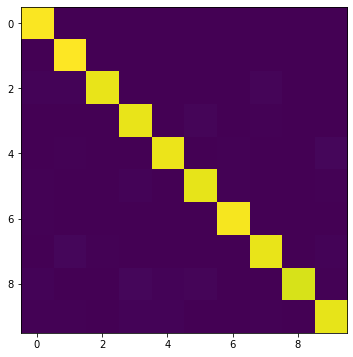

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.01 0.97 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.01 0.   0.01 0.   0.  ]
 [0.   0.01 0.   0.   0.97 0.   0.   0.   0.   0.02]
 [0.01 0.   0.   0.01 0.   0.96 0.01 0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.02 0.   0.   0.   0.   0.   0.96 0.   0.01]
 [0.01 0.   0.   0.02 0.01 0.01 0.   0.   0.94 0.  ]
 [0.   0.   0.   0.01 0.01 0.   0.   0.01 0.   0.96]]


In [118]:
# display confusion matrix for your KNN classifier with all the training examples
# (This may take a while)
""" ==========
YOUR CODE HERE
========== """

M, accuracy = Confusion(testData, testLabels, knnClassifer)
print ('KNN classifier accuracy: %f'%test(testData, testLabels, 
                                          knnClassifer))
VisualizeConfusion(M)

#### Answer: Based on the confusion matrix, the number '7' is most often predicted to be, other than 7 , are 2 , 3 ,and 9. The reason would be that there might be some fetures of 7 that are similar to 2,3,9, which cause the model throw 7 into wrong classification.


### Part 4: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN) [5 pts]
Here you will implement a simple KNN classifer in PCA space (for k=3 and 25 principal components).
You should implement PCA yourself using svd (you may not use sklearn.decomposition.PCA
or any other package that directly implements PCA transformations

Is the testing time for PCA KNN classifier more or less than that for KNN classifier? Comment on why it differs if it does.

In [7]:
import numpy as np
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

In [8]:
from sklearn.neighbors import KNeighborsClassifier
class PCAKNNClassifer():
    def __init__(self, components=25, k=3):
        # components = number of principal components
        # k is the number of neighbors involved in voting
        """ ==========
        YOUR CODE HERE
        ========== """
        self.model = KNeighborsClassifier(n_neighbors=k)
        self.components = components
        self.k = k
    
    def train(self, trainData, trainLabels):
        """ ==========
        YOUR CODE HERE
        ========== """
        
        data_len = len(trainData)
        trainData = np.reshape(trainData,(data_len, -1))
        trainData_subtract = trainData - np.mean(trainData, 0)
        trainCov = np.dot(trainData_subtract.T,trainData_subtract)
        U,s,Vh = np.linalg.svd(trainCov, compute_uv=True)
        V = Vh.T
        self.singular = V[:,:self.components]
        reconstruction = np.dot(trainData, self.singular)
        self.model.fit(reconstruction, trainLabels)

    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        """ ==========
        YOUR CODE HERE
        ========== """
        data_len = len(x)
        x = np.reshape(x,(data_len, -1))
        reconstruction = np.dot(x,self.singular)
        return self.model.predict(reconstruction)

# test your classifier with only the first 100 training examples (use this
# while debugging)
pcaknnClassiferX = PCAKNNClassifer()
pcaknnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN-PCA classifier accuracy: %f'%test(testData, testLabels, 
                                              pcaknnClassiferX))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



KNN-PCA classifier accuracy: 66.160000


In [9]:
# test your classifier with all the training examples
pcaknnClassifer = PCAKNNClassifer()
pcaknnClassifer.train(trainData, trainLabels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



KNN-PCA classifier accuracy: 97.310000


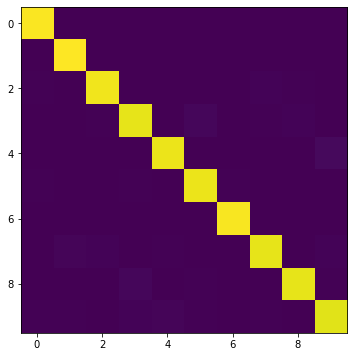

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.98 0.   0.   0.   0.   0.01 0.01 0.  ]
 [0.   0.   0.   0.96 0.   0.02 0.   0.01 0.01 0.  ]
 [0.   0.   0.   0.   0.97 0.   0.   0.   0.   0.02]
 [0.01 0.   0.   0.01 0.   0.97 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.01 0.01 0.   0.   0.   0.   0.96 0.   0.01]
 [0.   0.   0.   0.02 0.   0.01 0.   0.   0.96 0.  ]
 [0.   0.01 0.   0.01 0.01 0.   0.   0.   0.   0.95]]


In [13]:
# display confusion matrix for your PCA KNN classifier with all the training examples
""" ==========
YOUR CODE HERE
========== """
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))
M, accuracy = Confusion(testData, testLabels, pcaknnClassifer)
print ('KNN-PCA classifier accuracy: %f'%test(testData, testLabels, 
                                              pcaknnClassifer))
VisualizeConfusion(M)

#### Comments:
Your comments: based on our result, KNN classifier takes up to 11 mins and KNN-PCA classifier takes only 11 seconds to complete the evaluation. And they actually perform almost same accuracy up to 97%. The reason is that PCA-KNN method use the reduced dimension (784 > 25) to predict the test data, so the computation is much faster than KNN.

## Problem 3: Deep learning [14 pts]
Below is some helper code to train your deep networks.

### Part 1:  Training with PyTorch [2 pts]
Below is some helper code to train your deep networks. 
Complete the train function for DNN below. You should write down the training operations in this function. That means, for a batch of data you have to initialize the gradients, forward propagate the data, compute error, do back propagation and finally update the parameters. This function will be used in the following questions with different networks.
You can look at https://pytorch.org/tutorials/beginner/pytorch_with_examples.html for reference.

In [134]:
# base class for your deep neural networks. It implements the training loop (train_net).
# You will need to implement the "__init__()" function to define the networks
# structures and "forward()", to propagate your data, in the following problems.

import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from tqdm import tqdm
from scipy.stats import truncnorm

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        pass
    
    def forward(self, x):
        raise NotImplementedError
    
    def train_net(self, trainData, trainLabels, epochs=1, batchSize=50):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = 3e-4)
        
        for epoch in range(epochs):
            self.train()  # set netowrk in training mode
            for i, (data,labels) in enumerate(DataBatch(trainData, 
                                trainLabels, batchSize, shuffle=True)):
                data = Variable(torch.FloatTensor(data))
                labels = Variable(torch.LongTensor(labels))
                
                # YOUR CODE HERE------------------------------------------------
                # Train the model using the optimizer and the batch data
                pred = self.forward(data)
                loss = criterion(pred, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                    
                #------------------------------------------------------------------
                #-----End of your code, don't change anything else here------------
                
            self.eval()  # set network in evaluation mode
            print ('Epoch:%d Accuracy: %f'%(epoch+1, test(testData,
                                                testLabels, self))) 
    
    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.forward(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)

# helper function to get weight variable
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, 
                                         size=shape))
    return Parameter(initial, requires_grad=True)

# helper function to get bias variable
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return Parameter(initial, requires_grad=True)

In [135]:
# example linear classifier - input connected to output
# you can take this as an example to learn how to extend DNN class
class LinearClassifier(DNN):
    def __init__(self, in_features=28*28, classes=10):
        super(LinearClassifier, self).__init__()
        # in_features=28*28
        self.weight1 = weight_variable((classes, in_features))
        self.bias1 = bias_variable((classes))
    
    def forward(self, x):
        # linear operation
        y_pred = torch.addmm(self.bias1, x.view(list(x.size())[0], -1),
                             self.weight1.t())
        return y_pred
    
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
trainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
testData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

In [136]:
# test the example linear classifier (note you should get around 90% accuracy
# for 10 epochs and batchsize 50)
linearClassifier = LinearClassifier()
linearClassifier.train_net(trainData, trainLabels, epochs=10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch:1 Accuracy: 89.330000



Epoch:2 Accuracy: 90.710000



Epoch:3 Accuracy: 91.230000



Epoch:4 Accuracy: 91.620000



Epoch:5 Accuracy: 91.820000



Epoch:6 Accuracy: 91.960000



Epoch:7 Accuracy: 92.160000



Epoch:8 Accuracy: 92.250000



Epoch:9 Accuracy: 92.360000



Epoch:10 Accuracy: 92.400000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



linear classifier accuracy: 92.400000


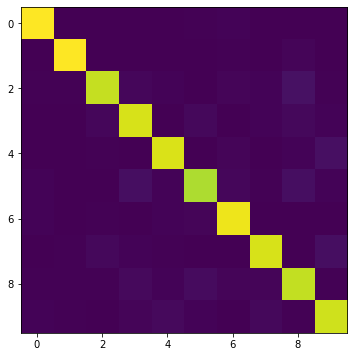

[[0.98 0.   0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.98 0.   0.   0.   0.   0.   0.   0.01 0.  ]
 [0.01 0.01 0.89 0.02 0.01 0.   0.01 0.01 0.04 0.  ]
 [0.   0.   0.02 0.92 0.   0.02 0.   0.01 0.02 0.01]
 [0.   0.   0.   0.   0.93 0.   0.01 0.   0.01 0.04]
 [0.01 0.   0.   0.04 0.01 0.86 0.02 0.01 0.04 0.01]
 [0.01 0.   0.01 0.   0.01 0.01 0.96 0.   0.   0.  ]
 [0.   0.01 0.02 0.01 0.01 0.   0.   0.92 0.   0.04]
 [0.01 0.   0.01 0.02 0.01 0.03 0.01 0.01 0.89 0.01]
 [0.01 0.01 0.   0.01 0.02 0.01 0.   0.02 0.01 0.91]]


In [138]:
# display confusion matrix
""" ==========
YOUR CODE HERE
========== """
M, accuracy = Confusion(testData, testLabels, linearClassifier)
print ('linear classifier accuracy: %f'%test(testData, testLabels, 
                                             linearClassifier))
VisualizeConfusion(M)

### Part 2: Single Layer Perceptron [2 pts]
The simple linear classifier implemented in the cell already performs quite well. Plot the filter weights corresponding to each output class (weights, not biases) as images. (Normalize weights to lie between 0 and 1 and use color maps like 'inferno' or 'plasma' for good results). Comment on what the weights look like and why that may be so.


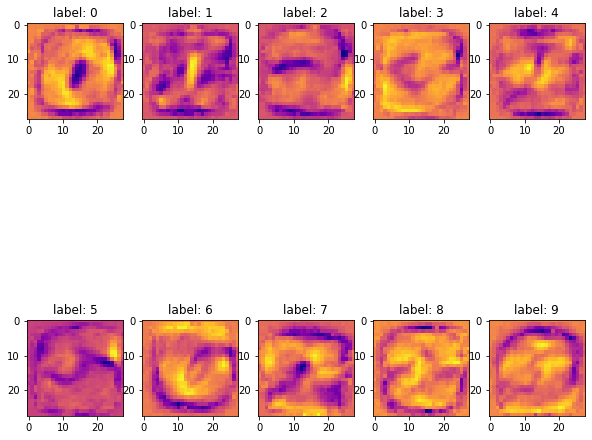

In [163]:
# Plot filter weights corresponding to each class, you may have to reshape them to make sense out of them
# linearClassifier.weight1.data will give you the first layer weights

weights = linearClassifier.weight1.data
fig, axs = plt.subplots(2,5, figsize = (10,10))
for i,w in enumerate(weights):
    w_img = w.reshape(28,28)
    w_img = np.array(w_img)
    w_min = np.min(w_img)
    w_max = np.max(w_img)
    w_img = (w_img-w_min) / (w_max-w_min) 
    #plt.figure()
    axs[i//5,i%5].imshow(w_img, cmap =  'plasma' )
    axs[i//5,i%5].title.set_text("label: {}".format(i))
plt.show()


#### Comments on weights
the displayed weight images look like the actual label, since the linear classifier is trying to find the features of each class. 

### Part 3: Multi Layer Perceptron (MLP) [5 pts]
Here you will implement an MLP. The MLP should consist of 2 layers (matrix multiplication and bias offset) that map to the following feature dimensions:

* 28x28 -> hidden (100)
* hidden -> classes

* The hidden layer should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output.
* The final output of the computation graph should be stored in self.y as that will be used in the training.

Display the confusion matrix and accuracy after training. Note: You should get ~ 97 % accuracy for 10 epochs and batch size 50.

Plot the filter weights corresponding to the mapping from the inputs to the first 10 hidden layer outputs (out of 100). Do the weights look similar to the weights plotted in the previous problem? Why or why not?

In [181]:
class MLPClassifer(DNN):
    def __init__(self, in_features=28*28, classes=10, hidden=100):
        """ ==========
        YOUR CODE HERE
        ========== """
        super(MLPClassifer, self).__init__()
        self.weight1 = weight_variable((hidden,in_features))
        self.weight2 = weight_variable((classes,hidden))
        self.bias1 = bias_variable((hidden))
        self.bias2 = bias_variable((classes))
        #raise NotImplementedError
    
    def forward(self, x):
        """ ==========
        YOUR CODE HERE
        ========== """
        
        h = torch.addmm(self.bias1 , x.view(list(x.size())[0], -1),
                        self.weight1.t())
        relu1 = h.clamp(min=0) ## perform relu function
        y_pred = torch.addmm(self.bias2, relu1, self.weight2.t())
        #print("type of y_pred: {}".format(y_pred.shape))
        return y_pred
        #raise NotImplementedError

mlpClassifer = MLPClassifer()
mlpClassifer.train_net(trainData, trainLabels, epochs=10, batchSize=50)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch:1 Accuracy: 91.230000



Epoch:2 Accuracy: 93.090000



Epoch:3 Accuracy: 94.100000



Epoch:4 Accuracy: 94.840000



Epoch:5 Accuracy: 95.430000



Epoch:6 Accuracy: 95.890000



Epoch:7 Accuracy: 96.270000



Epoch:8 Accuracy: 96.510000



Epoch:9 Accuracy: 96.840000



Epoch:10 Accuracy: 96.880000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



MLP classifier accuracy: 96.880000


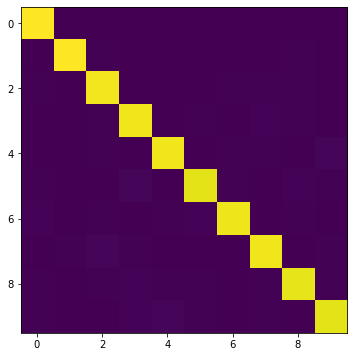

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.97 0.   0.   0.   0.01 0.01 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.01 0.   0.01 0.01 0.  ]
 [0.   0.   0.01 0.   0.97 0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.01 0.   0.95 0.01 0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.01 0.01 0.97 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.97 0.   0.01]
 [0.   0.   0.01 0.01 0.01 0.   0.   0.01 0.95 0.  ]
 [0.01 0.   0.   0.01 0.02 0.01 0.   0.   0.   0.95]]


In [197]:
# Plot confusion matrix
M, accuracy = Confusion(testData, testLabels, mlpClassifer)
print ('MLP classifier accuracy: %f'%test(testData, testLabels, 
                                          mlpClassifer))
VisualizeConfusion(M)

torch.Size([100, 784])


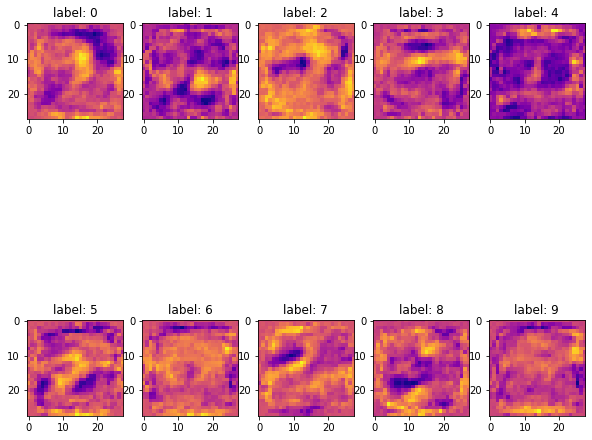

In [185]:
# Plot filter weights
weights = mlpClassifer.weight1.data
print(weights.shape)
#weights1 = weights[::10,:]
fig, axs = plt.subplots(2,5, figsize = (10,10))
for i,w in enumerate(weights[:10,:]):
    w_img = w.reshape(28,28)
    w_img = np.array(w_img)
    w_min = np.min(w_img)
    w_max = np.max(w_img)
    w_img = (w_img-w_min) / (w_max-w_min) 
    #plt.figure()
    axs[i//5,i%5].imshow(w_img, cmap =  'plasma' )
    axs[i//5,i%5].title.set_text("label: {}".format(i))
plt.show()

#### Comments on weights:

We cannot see clear number corresponding to the labels as we have seen in the previous session. It seems like the model have learn more complicated feature with the help of deeper network.

### Part 3: Convolutional Neural Network (CNN) [5 pts]
Here you will implement a CNN with the following architecture:

* n=5
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n) )
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n*2) )
* ReLU( Linear(hidden units = 64) )
* Linear(output_features=classes)

So, 2 convolutional layers, followed by 1 fully connected hidden layer and then the output layer

Display the confusion matrix and accuracy after training. You should get around ~ 98 % accuracy for 10 epochs and batch size 50.<br><br>
**Note: You are not allowed to use torch.nn.Conv2d() and torch.nn.Linear(), Using these will lead to deduction of points. Use the declared conv2d(), weight_variable() and bias_variable() functions.** Although, in practice, when you move forward after this class you will use torch.nn.Conv2d() which makes life easier and hides all the operations underneath.

In [194]:
def conv2d(x, W, stride):
    # x: input
    # W: weights (out, in, kH, kW)
    return F.conv2d(x, W, stride=stride, padding=2)

# Defining a Convolutional Neural Network
class CNNClassifer(DNN):
    def __init__(self, classes=10, n=5):
        super(CNNClassifer, self).__init__()
        """ ==========
        YOUR CODE HERE
        ========== """
        self.stride = 2
        self.classes = classes
        self.weight1 = weight_variable((n,1,5,5))
        self.weight2 = weight_variable((n*2,n,5,5))
        
        self.bias1 = bias_variable((n,14,14))
        self.bias2 = bias_variable((n*2,7,7))
        
        self.weight3= weight_variable((64,7*7*classes))
        self.bias3 = bias_variable((64))
        self.weight4= weight_variable((classes,64))
        self.bias4 = bias_variable((classes))
        
    def forward(self, x):
        """ ==========
        YOUR CODE HERE
        ========== """
        h1 = conv2d(x,self.weight1,self.stride)
        h1.add_(self.bias1)
        relu1 = h1.clamp(min=0)
        
        h2 = conv2d(relu1,self.weight2,self.stride)
        h2.add_(self.bias2)
        relu2 = h2.clamp(min=0)
        
        m,_,_,_ = relu2.size()
        vec = relu2.view(m,-1)
        h3 = torch.addmm(self.bias3 , vec, self.weight3.t())
        relu3 = h3.clamp(min=0) ## perform relu function
        y_pred = torch.addmm(self.bias4, relu3, self.weight4.t())
        return y_pred

cnnClassifer = CNNClassifer()
cnnClassifer.train_net(trainData, trainLabels, epochs=10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch:1 Accuracy: 90.280000



Epoch:2 Accuracy: 93.080000



Epoch:3 Accuracy: 94.560000



Epoch:4 Accuracy: 95.650000



Epoch:5 Accuracy: 96.180000



Epoch:6 Accuracy: 96.560000



Epoch:7 Accuracy: 97.170000



Epoch:8 Accuracy: 97.340000



Epoch:9 Accuracy: 97.570000



Epoch:10 Accuracy: 97.780000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CNN  classifier accuracy: 97.780000


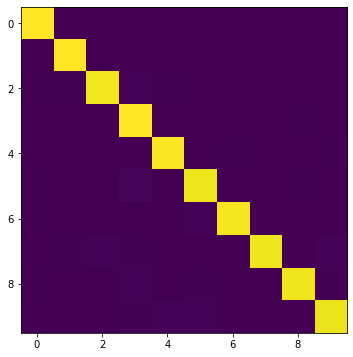

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.01 0.97 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.99 0.   0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.01 0.   0.97 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.97 0.   0.01]
 [0.01 0.   0.   0.01 0.   0.   0.   0.   0.97 0.  ]
 [0.   0.   0.   0.01 0.01 0.01 0.   0.   0.   0.96]]


In [196]:
# Plot Confusion matrix

M, accuracy = Confusion(testData, testLabels, cnnClassifer)
print ('CNN  classifier accuracy: %f'%test(testData, testLabels, 
                                           cnnClassifer))
VisualizeConfusion(M)

* Note that the MLP/ConvNet approaches lead to an accuracy a little higher than the K-NN approach. 
* In general, Neural net approaches lead to significant increase in accuracy, but in this case since the problem is not too hard, the increase in accuracy is not very high.
* However, this is still quite significant considering the fact that the ConvNets we've used are relatively simple while the accuracy achieved using K-NN is with a search over 60,000 training images for every test image.
* You can look at the performance of various machine learning methods on this problem at http://yann.lecun.com/exdb/mnist/
* You can learn more about neural nets/ pytorch at<br> https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* You can play with a demo of neural network created by Daniel Smilkov and Shan Carter at https://playground.tensorflow.org/